In [54]:
# imports
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import datetime as dt
import scipy
from scipy.optimize import curve_fit
from scipy.stats import pearsonr, norm, skewnorm, ks_2samp, poisson
from scipy.special import factorial
import matplotlib.dates as mdates
import imp
import numpy.random
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
from collections import OrderedDict
import pickle
#from natsort import natsorted, ns
from copy import deepcopy
import random

def round_nonzero(float_val):
    return(float("{0:.3g}".format(float_val)))

In [2]:
# # important note: all data shows local time (including daylight saving).
# # meteo-data was manually corrected beforehand, it also shows local time including daylight saving

# filename_EDM164 = 'data/SAQN_Messdaten_EDM164_OPC_002_gesamt.pickle'
# filename_ESP8266 = 'data/data-esp8266_all_sensors.pickle'
# filename_meteo = 'data/Meteo_21Oct-31Mai.pickle'
# filename_dylos = 'data/dylos_reference.pickle'



In [3]:
#interactive
def interactive(interactive):
    if interactive:
        %matplotlib
        import matplotlib.pyplot as plt
        plt.ion()
    if interactive == False:
        %matplotlib inline

# convert cm to inch for figsize
def cm2inch(value):
    return value/2.54
# used file formats for saving

# fileformats = ['pdf', 'eps', 'png', 'svg']
# fileformats = ['png', 'pdf']
fileformats = ['png']
dpi = 300
figsize=(cm2inch(30),cm2inch(10))

In [4]:
interactive(False)
# interactive(True)

In [5]:
# color palette for plots

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [6]:
# # load data from pickle files

# data = {}
# with open(filename_EDM164, 'rb') as handle:
#     data['EDM164'] = pickle.load(handle)
    
# with open(filename_ESP8266, 'rb') as handle:
#     data['ESP8266'] = pickle.load(handle)
    
# with open(filename_meteo, 'rb') as handle:
#     data['meteo'] = pickle.load(handle)
    
# with open(filename_dylos, 'rb') as handle:
#     data['dylos'] = pickle.load(handle)

In [7]:
###https://matthew-brett.github.io/teaching/string_formatting.html

# Working with the cleaned Data

In [8]:
# all_SDS_data_cleaned = {}
# with open("all_SDS_data_cleaned.pickle", 'rb') as handle:
#     all_SDS_data_cleaned = pickle.load(handle)
    
SDS_stat_calibrated = {}
with open("SDS_stat_calibrated.pickle", 'rb') as handle:
    SDS_stat_calibrated = pickle.load(handle)

In [9]:
calibrated_data = pd.DataFrame(index=SDS_stat_calibrated["ref"].keys(),columns=["PM10"])
# for i in range(len(SDS_stat_calibrated)):
#     time_stamp = SDS_stat_calibrated["ref"].keys()[i]
#     all_SDS_data_cleaned["PM10"][time_stamp] = [x for x in all_SDS_data["PM10"][i] if (np.isnan(x) != True)]

for thisdate in calibrated_data["PM10"].keys():
    calibrated_data["PM10"][thisdate] = []

for thissensor in SDS_stat_calibrated:
    for thisdate in SDS_stat_calibrated[thissensor].keys():
        if np.isnan(SDS_stat_calibrated[thissensor][thisdate]) == False: #filter out nans
            calibrated_data["PM10"][thisdate].append(SDS_stat_calibrated[thissensor][thisdate])

In [10]:
#use calibrated data
all_SDS_data_cleaned = calibrated_data

In [11]:
#add columns for mean, std and len of all values in that interval
mean_temp = []
std_temp = []
count_temp = []

for thisindex in all_SDS_data_cleaned["PM10"].keys():
    if len(all_SDS_data_cleaned["PM10"][thisindex]) < 2: #drop row if it has only one value
        all_SDS_data_cleaned = all_SDS_data_cleaned.drop(index=thisindex)

for thistuple in all_SDS_data_cleaned["PM10"]:
    mean_temp.append(np.mean(thistuple))
    std_temp.append(np.std(thistuple))
    count_temp.append(len(thistuple))

all_SDS_data_cleaned["mean"] = mean_temp
all_SDS_data_cleaned["std"] = std_temp
all_SDS_data_cleaned["count"] = count_temp

In [12]:
# sort all tuples, stds by the number of observations which they came from

count_of_observations = list(set(list(all_SDS_data_cleaned["count"])))
all_dates = all_SDS_data_cleaned["PM10"].keys()

#create empty dicts
tuple_list = {}
std_list = {}

#fill with empty lists
for eachnr in count_of_observations:
    std_list[str(eachnr)] = []
    tuple_list[str(eachnr)] = []

#fill lists with content
for thisdate in all_dates:
    current_count = str(all_SDS_data_cleaned["count"][thisdate])
    std_list[current_count].append(all_SDS_data_cleaned["std"][thisdate])
    tuple_list[current_count].append(all_SDS_data_cleaned["PM10"][thisdate])

    
    
    
# calculate the mean and std of all the stds
mean_of_std_list = {}
std_of_std_list = {}

for eachnr in std_list.keys():
    mean_of_std_list[str(eachnr)] = np.mean(std_list[str(eachnr)])
    std_of_std_list[str(eachnr)] = np.std(std_list[str(eachnr)])
    

In [13]:
# SDS_data_dates = {}    
# log_dates = {}
# std_list_dates = {}

# # upper_cutoff = 2000.0
# # lower_cutoff = -100.0

## Check whether there is a significant increase in std over time

In [14]:
# for min_data_threshold in range(2,10): #ignore if returns empty
                
#     SDS_data_dates[str(min_data_threshold)] = {}
#     log_dates[str(min_data_threshold)] = {}
#     std_list_dates[str(min_data_threshold)] = {} 

#     for year in ["2017","2018"]:
#         for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:

#             date = str(year) + "-" + str(month)

#             #sort observations into monthly intervals
#             for thisline in all_SDS_data_cleaned["PM10"][date]:


In [15]:
# for thisdate in month_logs["2"].keys():
#     print(thisdate + "   " + str(month_logs["2"][thisdate]["std_of_stds"]))
# #kein signifikanter alterungsprozess erkennbar... ist das überhaupt die richtige größe?

## For two values: calculate the difference

In [16]:
randomize_sign = False
absolute_differences = False
#max_difference = 1000 #absolute value


list_of_diffs = []
for thistuple in tuple_list["2"]:
    if absolute_differences == True:
        the_diff = abs(thistuple[0]-thistuple[1])/2 
    else:
        the_diff = (thistuple[0]-thistuple[1])/2
    if randomize_sign == True:
        rand_sign = random.choice([1,-1])
    else:
        rand_sign = 1
    list_of_diffs.append(rand_sign * the_diff)

print("Absolute Differences: " + str(absolute_differences) + ", Randomized_signs: " + str(randomize_sign))
print("mean and std of list_of_diffs: mean: " + str(round(np.mean(list_of_diffs),4)) + ", std: " + str(round(np.std(list_of_diffs),4)))

print("mean and std of two value fits: mean: " + str(round(mean_of_std_list["2"],4)) + ", std: " + str(round(std_of_std_list["2"],4)))


#for absolute_values = True it's the same thing: 
#taking (half) the (absolute!) differences and then fitting them
#OR fitting a distribution on two values and taking the stds and then fitting them again. std of two value is half the diff
#visuals below

Absolute Differences: False, Randomized_signs: False
mean and std of list_of_diffs: mean: -0.8622, std: 5.8228
mean and std of two value fits: mean: 3.6115, std: 4.6482


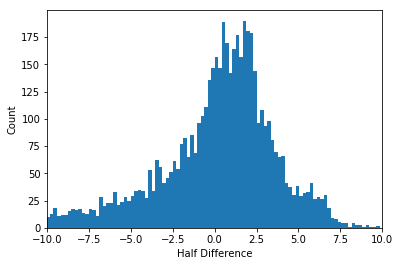

In [17]:
#%matplotlib inline
plt.hist(list_of_diffs, bins=300)
plt.ylabel('Count');
plt.xlabel('Half Difference');
plt.xlim(-10,10);

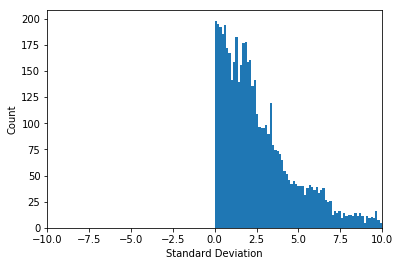

In [18]:
#%matplotlib inline
plt.hist(std_list["2"], bins=300)
plt.ylabel('Count');
plt.xlabel('Standard Deviation');
plt.xlim(-10,10);

# Check for Poisson Distribution

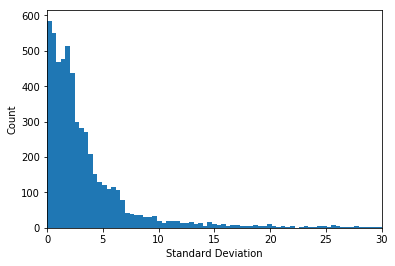

In [19]:
#%matplotlib inline
plt.hist(std_list["2"], bins=100)
plt.ylabel('Count');
plt.xlabel('Standard Deviation');
plt.xlim(0,30);

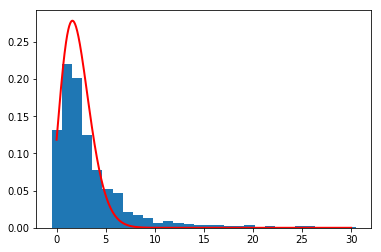

fitted poisson mu = 2.1334


In [20]:
#check for poisson distribution

# get poisson deviated random numbers
#data = np.random.poisson(2, 1000)
data=std_list["2"]


poisson_range = 30
# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=poisson_range, range=[-0.5, poisson_range + 0.5], density=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson_func(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson_func, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_poisson = np.linspace(0, poisson_range, 1000)

plt.plot(x_poisson, poisson_func(x_poisson, *parameters), 'r-', lw=2)
plt.show()

print("fitted poisson mu = " + str(parameters[0])[:6])

In [55]:
# KS sagt allen std_lists liegt die gleiche distribution zugrunde. das macht nur sinn, alles andere wäre unfug. 
#klappt nicht mehr, WARUM?

print("comparing 2 and 3 tuple results: p-value: " + str(round_nonzero(ks_2samp(std_list["2"],std_list["3"])[1])))

comparing 2 and 3 tuple results: p-value: 8.89e-11


comparing 2 and poisson fit: p-value: 2.0015818149537049e-109


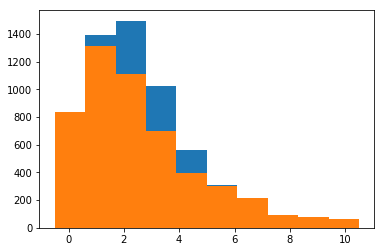

In [166]:
bincount = 10
std_poisson = std_list["2"]
random_poisson = np.random.poisson(parameters[0], len(std_poisson))

plt.hist(random_poisson, bins=bincount, range=[-0.5, bincount + 0.5]);
plt.hist(std_poisson, bins=bincount, range=[-0.5, bincount + 0.5]);

# KS sagt auch, es ist KEINE poisson distribution

print("comparing 2 and poisson fit: p-value: " + str(ks_2samp(std_poisson,random_poisson)[1]))

## Analyse difference without taking abs

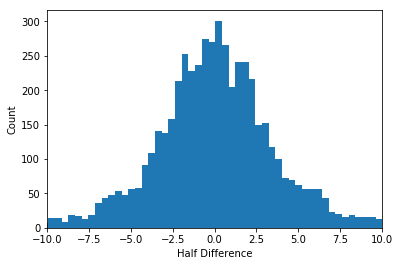

In [167]:
#%matplotlib inline
plt.hist(list_of_diffs, bins=100)
plt.ylabel('Count');
plt.xlabel('Half Difference');
plt.xlim(-10,10);

# Test for Skewed Normal Distribution

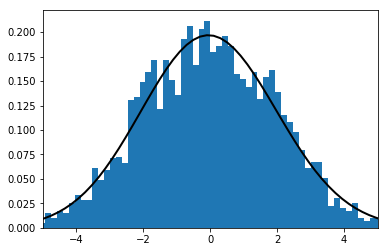

In [103]:
# choose some parameters
a_skew, mu, std = skewnorm.fit(list_of_diffs)
# Plot the PDF.
plt.figure()
plt.hist(list_of_diffs, bins=100, density=True)
plt.xlim(-5,5)

x = np.linspace(-10, 10, 100)
p = skewnorm.pdf(x,a_skew, mu, std)
plt.plot(x, p, 'k', linewidth=2);

In [104]:
print("a_skew = " + str(a_skew))
print("mu = " + str(mu))
print("std = " + str(std))

# KS sagt es ist auch keine skewed normalverteilung
ks_2samp(list_of_diffs,p)

a_skew = 0.6028782211907991
mu = -0.9328649556065316
std = 2.226976129112715


Ks_2sampResult(statistic=0.5089498806682577, pvalue=7.383685664958441e-23)

# Test wie sich differenz von normalverteilten werten verhält

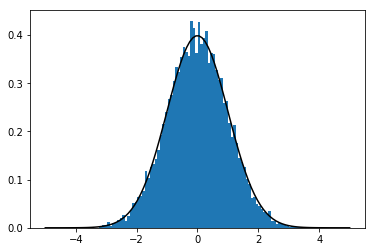

In [105]:
std_test = 1

x = np.linspace(-5, 5, 100)
p = norm.pdf(x,0,std_test)

y = np.random.normal(0, std_test, 10000);
plt.hist(y, bins=100, density=True);

plt.plot(x, p,'k');

mu: 0.00037564319389541084   std: 1.421023225694716


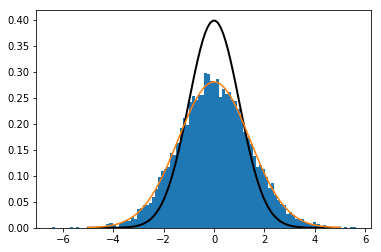

In [106]:
y_2 = np.random.normal(0, std_test, 10000);
y_diff = y-y_2
plt.hist(y_diff, bins=100, density=True);

plt.plot(x, p, 'k', linewidth=2);

mu_2, std_2 = norm.fit(y_diff)
p_2 = norm.pdf(x, mu_2, std_2)
plt.plot(x, p_2);
print("mu: " + str(mu_2) + "   std: " + str(std_2))

### Differenz von zwei Normalverteilungen ist auch Normalverteilung mit 1.4 facher std

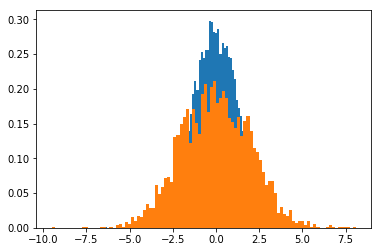

In [107]:
plt.hist(y_diff, bins=100, density=True);
plt.hist(list_of_diffs, bins=100, density=True);

In [108]:
print("vgl mit data, p value: " + str(round(ks_2samp(list_of_diffs,y_diff)[1],6)))

vgl mit data, p value: 0.0


### KS sagt werte kommen auch nicht aus differenz von normalverteilungen

# Calculate the difference of values from a skewed normal distribution and compare with the data

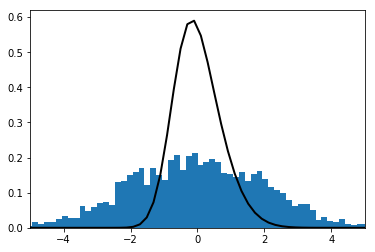

In [116]:
# guess some parameters
a_skew, mu, std = (2,-0.7,1)

#skew function for comparison
x = np.linspace(-10, 10, 100)
p = skewnorm.pdf(x,a_skew, mu, std)
plt.xlim(-5,5)

# Plot the PDF.
plt.hist(list_of_diffs, bins=100, density=True)
plt.plot(x, p, 'k', linewidth=2);

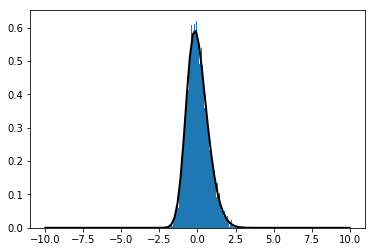

In [110]:
#code for generate random numbers based on skewed normal distribution and comparison with fit function

r = skewnorm.rvs(a_skew, mu, std,size=10000)
plt.hist(r,bins=100,density=True);

plt.plot(x,p, 'k', linewidth=2);

Generating Distribution: 
mu: -0.7   std: 1   a_skew: 2
Difference Distribution: 
mu: 0.0163   std: 0.9909


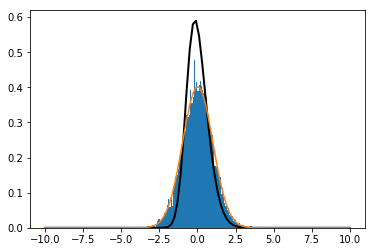

In [111]:
r_2 = skewnorm.rvs(a_skew, mu, std,size=10000)
r_diff = r-r_2
plt.hist(r_diff, bins=100, density=True);

plt.plot(x, p, 'k', linewidth=2);

mu_2, std_2 = norm.fit(r_diff)
p_2 = norm.pdf(x, mu_2, std_2)
plt.plot(x, p_2);
print("Generating Distribution: ")
print("mu: " + str(mu) + "   std: " + str(std) + "   a_skew: " + str(a_skew))
print("Difference Distribution: ")
print("mu: " + str(mu_2)[:6] + "   std: " + str(std_2)[:6])

In [112]:
norm_comparison = norm.rvs(mu_2, std_2, size=500)
print("p-value: " + str(ks_2samp(r_diff,norm_comparison)[1]))

p-value: 0.35479412490077294


### Differenz zweier Skewed Normalverteilungen ist immer Normalverteilung (!) Skew beeinflusst nur die std

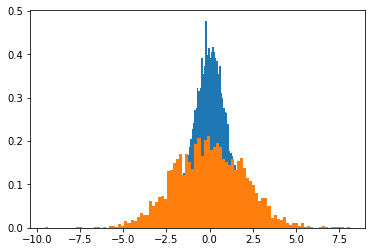

In [113]:
plt.hist(r_diff, bins=100, density=True);
plt.hist(list_of_diffs, bins=100, density=True);

In [114]:
# sehe hier möglicherweise den offset eines sensors gegenüber einem anderen 
#--> differenz in eine Richtung verschoben, müsste es zufällig machen welche zahl ich von welcher abziehe
#--> auch mit random sign auf den differenzen klappts nicht. wird symmetrisch aber ist unten zu breit und oben zu steil
# --> spricht aber für einen systematischen fehler: zu viele zu hohe werte? allerdings nicht nachvollziehbar, da ich
#   differenzen zum gleichen zeitpunkt (alter) und gleicher wertehöhe anschaue... 
#   allerdings: wenn die streuung zunimmt, dann bekomme ich auch höhere differenzen mit höherer wahrscheinlichkeit!
# --> verschieden zeiten anschauen
# --> werthöhen unterscheiden

#KS sagt werte kommen auch nicht aus differenz von normalverteilungen
ks_2samp(list_of_diffs,r_diff)

Ks_2sampResult(statistic=0.18492124105011934, pvalue=2.344578308279521e-75)

In [115]:
norm.fit(list_of_diffs)

(-0.015521114723458804, 2.029258330217325)